In [5]:
#Import libraries:
import pandas as pd
import numpy as np
import xgboost as xgb
from xgboost.sklearn import XGBRegressor
from sklearn import metrics   #Additional scklearn functions
from sklearn.model_selection import GridSearchCV
import matplotlib.pylab as plt
import os
from decimal import Decimal
from matplotlib.pylab import rcParams
import random

#rcParams['figure.figsize'] = 12, 4

#train = pd.read_csv('Train_Modified.csv', encoding='ISO-8859–1')
#target = 'Disbursed'
#IDcol = 'ID'

#print("There will be no output for this particular block of code")

In [6]:
DataLocation = os.path.join('..', 'data')
os.chdir(DataLocation)

y_var='Recharge RC 50% mm/y'
y_predict='R50'
aus_file='Australia_grid_0p05_data.csv'
seed=42
random.seed(seed)
random_num = random.randint(0, 1000)

df = pd.read_csv('dat07_u.csv', low_memory=False).sample(frac=1, random_state=seed)
df.dropna(subset=['Rain mm/y', 'koppen_geiger', 'PET mm/y', 'distance_to_coast_km', 'Aridity', 'elevation_mahd', 'wtd_mbgs', 'regolith_depth_mbgs', 'slope_perc', 'clay_perc', 'silt_perc', 'sand_perc', 'soil_class', 'geology', 'ndvi_avg', 'vegex_cat', 'rainfall_seasonality'], inplace=True)
print(f"nans removed, removed {len(df) - len(df.dropna())}, removed {Decimal(100 * (len(df) - len(df.dropna()))/len(df)).quantize(Decimal('1.0'))}%")
print(f"Remaining data has mean Rrc/P ratio: {Decimal(np.nanmean(df['Rrc/P'])).quantize(Decimal('1.00'))}")

train_params = ['Rain mm/y', 'rainfall_seasonality', 'PET mm/y', 'elevation_mahd', 'distance_to_coast_km', 'ndvi_avg', 'clay_perc', 'soil_class']

aus_X = pd.read_csv(aus_file)[train_params]

nans removed, removed 0, removed 0.0%
Remaining data has mean Rrc/P ratio: 0.04


In [39]:
def modelfit(alg, Xtrain, ytrain, useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(Xtrain, ytrain)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='rmse', early_stopping_rounds=early_stopping_rounds)
        alg.set_params(n_estimators=cvresult.shape[0])
        print(f'Optimal n_estimators: {cvresult.shape[0]}')
    
    #Fit the algorithm on the data
    alg.fit(Xtrain, ytrain)
        
    #Predict training set:
    dtrain_predictions = alg.predict(Xtrain)
        
    #Print model report:
    print("\nModel Report")
    print("RMSE : %.4g" % np.sqrt(metrics.mean_squared_error(ytrain, dtrain_predictions)))
    print("R2 Score : %.4g" % metrics.r2_score(ytrain, dtrain_predictions))
                    
    # Update this line to use get_booster().get_score()
    feat_imp = pd.Series(alg.get_booster().get_score(importance_type='weight')).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')

Optimal n_estimators: 350

Model Report
RMSE : 47.31


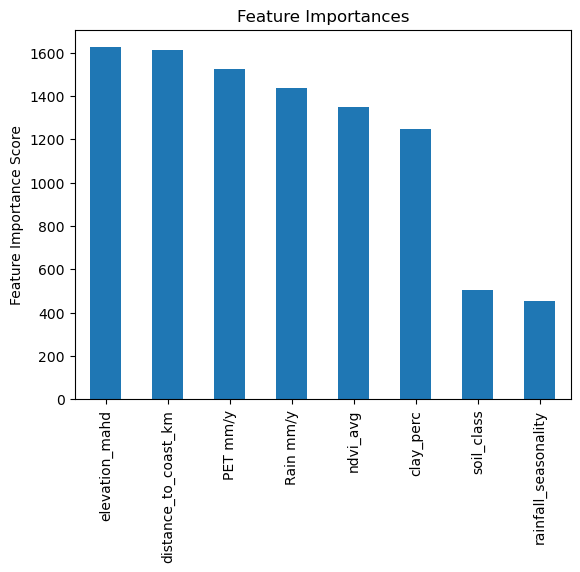

In [22]:
#Choose all predictors except target & IDcols
xgb1 = XGBRegressor(
 learning_rate=0.1,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective='reg:squarederror',  # Changed to regression objective
 nthread=4,
 seed=27)

train_data_file = 'train_data.csv'
train_data = pd.read_csv(train_data_file)
train_params = ['Rain mm/y', 'rainfall_seasonality', 'PET mm/y', 'elevation_mahd', 'distance_to_coast_km', 'ndvi_avg', 'clay_perc', 'soil_class']
y_var='Recharge RC 50% mm/y'
Xtrain = train_data[train_params]
ytrain = train_data[y_var]

modelfit(xgb1, Xtrain, ytrain)

In [23]:
param_test1 = {
 'max_depth': range(3, 10, 2),
 'min_child_weight': range(1, 6, 2)
}
gsearch1 = GridSearchCV(estimator = XGBRegressor(learning_rate=0.1, n_estimators=350, max_depth=5,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective='reg:squarederror', nthread=4, seed=27), 
 param_grid=param_test1, scoring='neg_mean_squared_error', n_jobs=4, cv=5)
gsearch1.fit(Xtrain, ytrain)
gsearch1.cv_results_, gsearch1.best_params_, gsearch1.best_score_

({'mean_fit_time': array([ 2.19262772,  2.31739845,  2.32206817,  3.88438692,  4.51589856,
          4.6126267 ,  6.68341103,  6.5339643 ,  6.59016619, 10.78110909,
         10.37759399,  8.7390718 ]),
  'std_fit_time': array([0.02395262, 0.16502744, 0.08840993, 0.21865719, 0.10916316,
         0.22870335, 0.1725421 , 0.21116113, 0.29885422, 0.36502388,
         0.36126885, 0.8310498 ]),
  'mean_score_time': array([0.04605498, 0.04326272, 0.04798746, 0.11550951, 0.08092275,
         0.10697389, 0.1230051 , 0.11874852, 0.11127086, 0.18243909,
         0.15471816, 0.16402545]),
  'std_score_time': array([0.01222468, 0.01000585, 0.0058786 , 0.03184052, 0.00856441,
         0.01721245, 0.0177563 , 0.00958297, 0.00965909, 0.02287251,
         0.0181955 , 0.01826678]),
  'param_max_depth': masked_array(data=[3, 3, 3, 5, 5, 5, 7, 7, 7, 9, 9, 9],
               mask=[False, False, False, False, False, False, False, False,
                     False, False, False, False],
         fill_value=99

In [24]:
param_test2 = {
 'max_depth':[4,5,6],
 'min_child_weight':[1, 2]
}

gsearch2 = GridSearchCV(estimator = XGBRegressor(learning_rate=0.1, n_estimators=350, max_depth=5,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective='reg:squarederror', nthread=4, seed=27), 
 param_grid=param_test2, scoring='neg_mean_squared_error', n_jobs=4, cv=5)
gsearch2.fit(Xtrain, ytrain)
gsearch2.cv_results_, gsearch2.best_params_, gsearch2.best_score_

({'mean_fit_time': array([2.412358  , 2.90162234, 4.86516786, 5.0625567 , 5.74843607,
         4.78362527]),
  'std_fit_time': array([0.01452457, 0.5175733 , 0.49854959, 0.11791853, 0.07577633,
         1.14313667]),
  'mean_score_time': array([0.05941391, 0.06478186, 0.08096952, 0.08263826, 0.08835802,
         0.08924646]),
  'std_score_time': array([0.01470041, 0.01714946, 0.00476343, 0.00559353, 0.00405954,
         0.00757468]),
  'param_max_depth': masked_array(data=[4, 4, 5, 5, 6, 6],
               mask=[False, False, False, False, False, False],
         fill_value=999999),
  'param_min_child_weight': masked_array(data=[1, 2, 1, 2, 1, 2],
               mask=[False, False, False, False, False, False],
         fill_value=999999),
  'params': [{'max_depth': 4, 'min_child_weight': 1},
   {'max_depth': 4, 'min_child_weight': 2},
   {'max_depth': 5, 'min_child_weight': 1},
   {'max_depth': 5, 'min_child_weight': 2},
   {'max_depth': 6, 'min_child_weight': 1},
   {'max_depth': 6, '

In [27]:
param_test3 = {
 'gamma':[i/10.0 for i in range(0,5)]
}
gsearch3 = GridSearchCV(estimator = XGBRegressor(learning_rate=0.1, n_estimators=350, max_depth=6,
 min_child_weight=2, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective='reg:squarederror', nthread=4, seed=27), 
 param_grid=param_test3, scoring='neg_mean_squared_error', n_jobs=4, cv=5)
gsearch3.fit(Xtrain, ytrain)
gsearch3.cv_results_, gsearch3.best_params_, gsearch3.best_score_

({'mean_fit_time': array([5.38648081, 5.65654602, 5.4427052 , 5.06211643, 5.37295446]),
  'std_fit_time': array([0.25146438, 0.31269185, 0.18175654, 0.36307784, 1.43159108]),
  'mean_score_time': array([0.16008959, 0.12304692, 0.11677952, 0.08735957, 0.08326707]),
  'std_score_time': array([0.04039297, 0.0180562 , 0.02449232, 0.00837743, 0.00361737]),
  'param_gamma': masked_array(data=[0.0, 0.1, 0.2, 0.3, 0.4],
               mask=[False, False, False, False, False],
         fill_value=1e+20),
  'params': [{'gamma': 0.0},
   {'gamma': 0.1},
   {'gamma': 0.2},
   {'gamma': 0.3},
   {'gamma': 0.4}],
  'split0_test_score': array([-2908.94730956, -2908.94730956, -2908.94730956, -2916.21628433,
         -2916.21628433]),
  'split1_test_score': array([-2843.48731872, -2843.48731872, -2843.48731872, -2843.48731872,
         -2843.48731872]),
  'split2_test_score': array([-2903.31002888, -2903.31002888, -2903.31002888, -2903.31002888,
         -2903.31002888]),
  'split3_test_score': array([

In [30]:
param_test4 = {
 'subsample':[i/10.0 for i in range(6,10)],
 'colsample_bytree':[i/10.0 for i in range(6,10)]
}
gsearch4 = GridSearchCV(estimator = XGBRegressor(learning_rate=0.1, n_estimators=350, max_depth=6,
 min_child_weight=2, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective='reg:squarederror', nthread=4, seed=27), 
 param_grid=param_test4, scoring='neg_mean_squared_error', n_jobs=4, cv=5)
gsearch4.fit(Xtrain, ytrain)
gsearch4.cv_results_, gsearch4.best_params_, gsearch4.best_score_

({'mean_fit_time': array([6.20276823, 5.32349463, 5.32695599, 5.3667016 , 5.14732623,
         5.01986303, 4.64679418, 5.25968018, 5.08301425, 4.97188678,
         5.30724173, 5.11937842, 4.82323236, 5.16851034, 5.32841296,
         5.45987158]),
  'std_fit_time': array([0.14777908, 0.71150653, 0.64873257, 0.224711  , 0.07732812,
         0.28266852, 0.07638355, 0.37959748, 0.14332908, 0.14979911,
         0.18813898, 0.22661828, 0.03059815, 0.4924764 , 0.38140543,
         0.20679448]),
  'mean_score_time': array([0.19533658, 0.09987078, 0.09668398, 0.1023489 , 0.0976583 ,
         0.08647127, 0.09195347, 0.11931772, 0.09448094, 0.08414822,
         0.10762529, 0.09769382, 0.0903501 , 0.08855791, 0.08431315,
         0.09830236]),
  'std_score_time': array([0.05715782, 0.01640616, 0.01329426, 0.01942757, 0.01627041,
         0.0029736 , 0.01494449, 0.02423801, 0.00997625, 0.00430597,
         0.03184499, 0.01601659, 0.0081842 , 0.00506719, 0.00183121,
         0.01074484]),
  'param_c

In [34]:
param_test5 = {
 'subsample':[i/100.0 for i in range(85,100,5)],
 'colsample_bytree':[i/100.0 for i in range(55,70,5)]
}
gsearch5 = GridSearchCV(estimator = XGBRegressor(learning_rate=0.1, n_estimators=350, max_depth=6,
 min_child_weight=2, gamma=0, subsample=0.9, colsample_bytree=0.6,
 objective='reg:squarederror', nthread=4, seed=27), 
 param_grid=param_test5, scoring='neg_mean_squared_error', n_jobs=4, cv=5)
gsearch5.fit(Xtrain, ytrain)
gsearch5.cv_results_, gsearch5.best_params_, gsearch5.best_score_

({'mean_fit_time': array([4.28816748, 6.15347538, 5.3064908 , 5.1287611 , 6.07392573,
         4.69870019, 4.48867121, 4.67607117, 5.13852625]),
  'std_fit_time': array([1.10719204, 0.52466799, 0.19028755, 0.08702481, 0.57172285,
         0.23980484, 0.05202474, 0.14664043, 1.35367519]),
  'mean_score_time': array([0.09920473, 0.12287664, 0.09964762, 0.08508577, 0.10028434,
         0.0938179 , 0.09192896, 0.0927145 , 0.08179483]),
  'std_score_time': array([0.01751722, 0.03971224, 0.01003615, 0.0050715 , 0.01061767,
         0.00801548, 0.0046575 , 0.01295055, 0.01290921]),
  'param_colsample_bytree': masked_array(data=[0.55, 0.55, 0.55, 0.6, 0.6, 0.6, 0.65, 0.65, 0.65],
               mask=[False, False, False, False, False, False, False, False,
                     False],
         fill_value=1e+20),
  'param_subsample': masked_array(data=[0.85, 0.9, 0.95, 0.85, 0.9, 0.95, 0.85, 0.9, 0.95],
               mask=[False, False, False, False, False, False, False, False,
                

In [35]:
param_test6 = {
 'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]
}
gsearch6 = GridSearchCV(estimator = XGBRegressor(learning_rate=0.1, n_estimators=350, max_depth=6,
 min_child_weight=2, gamma=0, subsample=0.95, colsample_bytree=0.55,
 objective='reg:squarederror', nthread=4, seed=27), 
 param_grid=param_test6, scoring='neg_mean_squared_error', n_jobs=4, cv=5)
gsearch6.fit(Xtrain, ytrain)
gsearch6.cv_results_, gsearch6.best_params_, gsearch6.best_score_

({'mean_fit_time': array([3.31910033, 3.84593949, 4.96192975, 5.25163026, 4.51287904]),
  'std_fit_time': array([0.12177727, 0.49957453, 0.2763519 , 0.12690993, 0.8181044 ]),
  'mean_score_time': array([0.06846976, 0.09643397, 0.09565959, 0.08610039, 0.11642547]),
  'std_score_time': array([0.01234795, 0.01612054, 0.00756007, 0.00858082, 0.02627023]),
  'param_reg_alpha': masked_array(data=[1e-05, 0.01, 0.1, 1.0, 100.0],
               mask=[False, False, False, False, False],
         fill_value=1e+20),
  'params': [{'reg_alpha': 1e-05},
   {'reg_alpha': 0.01},
   {'reg_alpha': 0.1},
   {'reg_alpha': 1},
   {'reg_alpha': 100}],
  'split0_test_score': array([-2860.32975882, -2853.84398804, -2867.82679697, -2865.75397595,
         -2850.12067228]),
  'split1_test_score': array([-2854.41258196, -2854.4171769 , -2835.12627426, -2835.87702605,
         -2839.14256024]),
  'split2_test_score': array([-2837.04927136, -2842.33515939, -2822.49679829, -2816.36279907,
         -2853.98453895]),


Optimal n_estimators: 350

Model Report
RMSE : 44.36
R2 Score : 0.8048


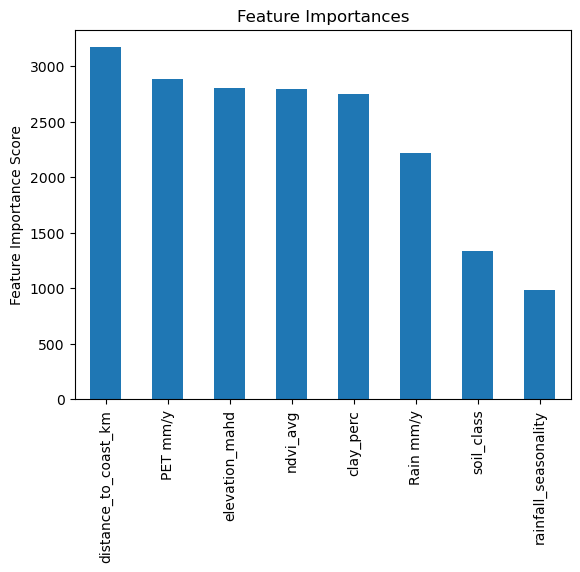

In [40]:
#Choose all predictors except target & IDcols
xgb3 = XGBRegressor(
 learning_rate=0.1,
 n_estimators=350,
 max_depth=6,
 min_child_weight=2,
 gamma=0,
 subsample=0.95,
 colsample_bytree=0.55,
 objective='reg:squarederror',  # Changed to regression objective
 nthread=4,
 seed=27,
 reg_alpha = 1)

modelfit(xgb3, Xtrain, ytrain)

Optimal n_estimators: 2908

Model Report
RMSE : 45.26
R2 Score : 0.7967


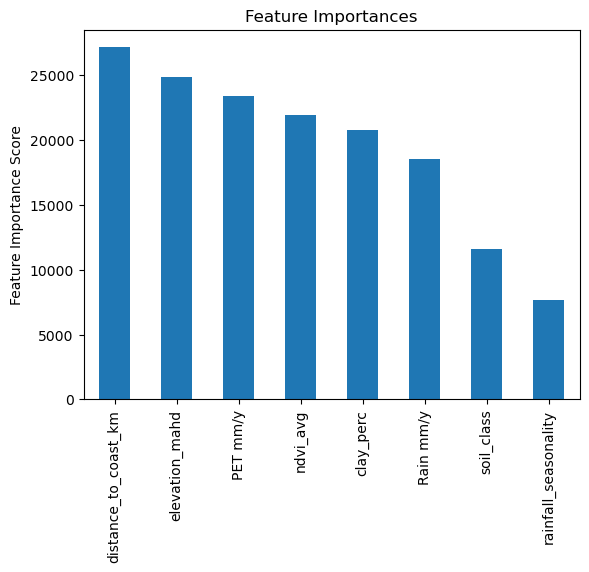

In [41]:
xgb4 = XGBRegressor(
 learning_rate=0.01,
 n_estimators=5000,
 max_depth=6,
 min_child_weight=2,
 gamma=0,
 subsample=0.95,
 colsample_bytree=0.55,
 reg_alpha=1,
 objective='reg:squarederror',  # Changed to regression objective
 nthread=4,
 seed=27)
modelfit(xgb4, Xtrain, ytrain)